In [2]:
import os
import h5py
import random
import numpy as np
from collections import defaultdict

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(font_scale = 1.8)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['xtick.labelsize'] = 18
# matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.xmargin'] = 0.1
matplotlib.rcParams['axes.ymargin'] = 0.1
matplotlib.rc('font', **{'weight': 'normal', 'size': 28})
# plt.style.use('dark_background')

BASE = "../data/openacc/raw/"
all_datasets = []
for name in os.listdir(BASE):
    if os.path.isdir(BASE + name) and name not in { 'One_vehicle_multiple_drivers_on_road_campaign' }:
        all_datasets.append(BASE + name + "/")
        
toyota_data = None
with h5py.File("../data/toyota/preprocessed/total_data.hdf5", 'r') as f:
    toyota_data = np.array(list(zip(
        f['user'][:], 
        # f['disc_dist'][:], 
        f['dist'][:],
        # Logging policy dependent context
        f['time_gap'][:], f['speed'][:], f['curr_acc'][:], 
        # Logging policy independent context
        f['lead_speed'][:], f['weather'][:], f['vehicle'][:]
    )))
    
toyota_per_user_data = defaultdict(list)
for user, dist, *_ in toyota_data:
    toyota_per_user_data[user].append(dist)
    
once_data = None
with h5py.File("../data/once/preprocessed/total_data.hdf5", 'r') as f:
    once_data = np.array(list(zip(
        f['user'][:], 
        # f['disc_dist'][:], 
        f['dist'][:],
        # Logging policy dependent context
        f['time_gap'][:], f['speed'][:], f['curr_acc'][:], 
        # Logging policy independent context
        f['lead_speed'][:], f['weather'][:], f['vehicle'][:]
    )))
    
once_per_user_data = defaultdict(list)
for user, dist, *_ in once_data:
    once_per_user_data[user].append(dist)

FileNotFoundError: [Errno 2] No such file or directory: '../data/openacc/raw/'

## Check how much data is manual vs. ACC

In [4]:
total_files = 0
manual_files, manual_cars_in_each_file = [], []

for d in all_datasets:
    all_files = [ d + file for file in os.listdir(d) if file.endswith(".csv") and not file.endswith("cations.csv") ]
    for file in all_files:
        f = open(file, 'r') ; lines = f.readlines() ; f.close()
        
        drive_type_indices = [ at for at, col in enumerate(lines[5].strip().split(",")) if col.startswith("Driver") ]
        drive_type_indices = drive_type_indices[1:] # Leader driver doesn't matter as it doesn't have a valid gap
        driver_types = [ set() for _ in drive_type_indices ]
        
        given_manual = False
        for line in lines[:6]:
            line = line.strip().split(",")
            if line[0] == "ACC" and line[1] in { '0', '2' }: 
                given_manual = True
                break
        
        for line in lines[6:]:
            line = line.strip().split(",")
            for at, i in enumerate(drive_type_indices):
                driver_types[at].add(line[i])
    
        atleast_one_human, human_drive_indices = False, []
        for at, d in enumerate(driver_types):
            if len(d) == 1 and list(d)[0] == 'Human': 
                atleast_one_human = True
                human_drive_indices.append(at)
                
        if given_manual and not atleast_one_human:
            human_drive_indices.append(0)
                
        if atleast_one_human or given_manual:
            manual_files.append(file)
            manual_cars_in_each_file.append(human_drive_indices)
        
        total_files += 1
        
print("# manual trajectories:", len(manual_files))
print("# total trajectories:", total_files)
print("-" * 30)
print("% manual trajectories:", 100.0 * (len(manual_files) / total_files))

# manual trajectories: 36
# total trajectories: 140
------------------------------
% manual trajectories: 25.71428571428571


## Check data distribution

In [10]:
all_trajectories = []

for file_num, file in enumerate(manual_files):
    f = open(file, 'r') ; lines = f.readlines() ; f.close()
    
    gap_indices = [ at for at, col in enumerate(lines[5].strip().split(",")) if col.startswith("IVS") ]
    speed_indices = [ at for at, col in enumerate(lines[5].strip().split(",")) if col.startswith("Speed") ]
    if len(gap_indices) != len(speed_indices) - 1:
        continue
    assert len(gap_indices) == len(speed_indices) - 1
    
    this_trajectories = [ [] for _ in gap_indices ] # No leader trajectory stored
    
    for line in lines[6:]:
        line = line.strip().split(",")
        
        for at, i in enumerate(gap_indices):
            try:
                this_trajectories[at].append([
                    float(line[i]), float(line[speed_indices[at + 1]])
                ])
            except:
                this_trajectories[at].append([ None, None ])

    for car_index in manual_cars_in_each_file[file_num]:
        all_trajectories.append(this_trajectories[car_index])

toyota_users = int(max(toyota_data[:, 0]) - min(toyota_data[:, 0])) + 1
once_users = int(max(once_data[:, 0]) - min(once_data[:, 0])) + 1
print("# of trajectories (Toyota):", toyota_users)
print("# of trajectories (ONCE):", once_users)
print("# of trajectories (openACC):", len(all_trajectories))
print("-" * 30)
print("Avg. duration of user trajectory in minutes (Toyota):", toyota_data.shape[0] / (600 * toyota_users))
print("Avg. duration of user trajectory in minutes (ONCE):", once_data.shape[0] / (120 * once_users))
print("Avg. duration of user trajectory in minutes (openACC):", len(sum(all_trajectories, [])) / (600 * len(all_trajectories)))
print("-" * 30)
print("Avg. length of user trajectory (Toyota):", toyota_data.shape[0] / (toyota_users))
print("Avg. length of user trajectory (ONCE):", once_data.shape[0] / (once_users))
print("Avg. length of user trajectory (openACC):", len(sum(all_trajectories, [])) / (len(all_trajectories)))
print("-" * 30)
print("Median length of user trajectory (Toyota):", np.median([ len(toyota_per_user_data[u]) for u in toyota_per_user_data ]))
print("Median length of user trajectory (Toyota):", np.median([ len(once_per_user_data[u]) for u in once_per_user_data ]))
print("Median length of user trajectory (openACC):", np.median(list(map(len, all_trajectories))))

# of trajectories (Toyota): 20
# of trajectories (ONCE): 10
# of trajectories (openACC): 46
------------------------------
Avg. duration of user trajectory in minutes (Toyota): 4.097416666666667
Avg. duration of user trajectory in minutes (ONCE): 6.898333333333333
Avg. duration of user trajectory in minutes (openACC): 14.425326086956522
------------------------------
Avg. length of user trajectory (Toyota): 2458.45
Avg. length of user trajectory (ONCE): 827.8
Avg. length of user trajectory (openACC): 8655.195652173914
------------------------------
Median length of user trajectory (Toyota): 2738.0
Median length of user trajectory (Toyota): 900.5
Median length of user trajectory (openACC): 5556.0


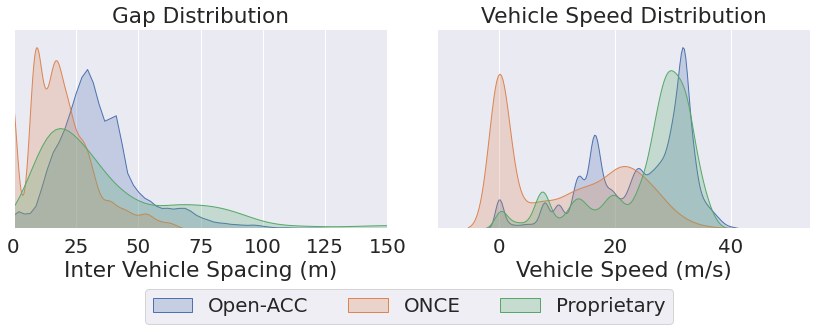

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

sns.kdeplot(sum(list(map(lambda x: list(map(lambda y: y[0], x)), all_trajectories)), []), shade=True, ax = ax[0], label = "Open-ACC")
sns.kdeplot(once_data[:, 1], shade=True, ax = ax[0], label = "ONCE")
# sns.histplot(sum(list(map(lambda x: list(map(lambda y: y[0], x)), all_trajectories)), []), ax = ax[0, 0]).set_title("openACC - Gap")
sns.kdeplot(toyota_data[:, 1], ax = ax[0], shade = True, label = "Proprietary").set_title("Gap Distribution")

sns.kdeplot(sum(list(map(lambda x: list(map(lambda y: y[1], x)), all_trajectories)), []), ax = ax[1], shade = True)
sns.kdeplot(once_data[:, 3], ax = ax[1], shade = True)
sns.kdeplot(toyota_data[:, 3], ax = ax[1], shade = True).set_title("Vehicle Speed Distribution")

ax[0].set_xlabel("Inter Vehicle Spacing (m)")
ax[1].set_xlabel("Vehicle Speed (m/s)")

ax[0].set_xlim(0, 150)

for a in [ ax[0], ax[1] ]:
    a.set_ylabel("")
    a.set_yticks([])

fig.tight_layout()
plt.subplots_adjust(bottom = 0.3)
fig.legend(ncol = 3, loc = 8)
fig.show()

fig.savefig("data_distribution.pdf")
fig.savefig("data_distribution.png")